# Spoken Language Processing 2023-24

# Lab3 - Dialogue Systems

_Bruno Martins_


This lab assignment will introduce tools and concepts related to the development of dialogue systems, exemplifying also the use of automatic speech recognition and text-to-speech models in this particular context.

Students will be tasked with the development of a simple (spoken/conversational) question answering system, reusing different models associated to the HuggingFace Transformers library:

* Speech recognition models (e.g., OpenAI Whisper).
* Large language models for natural language understanding and generation (e.g., [LaMini-GPT2](https://huggingface.co/MBZUAI/LaMini-GPT-124M) models).
* Text-to-speech models (e.g., SpeechT5).

The first parts of this notebook will guide students in the use of the tools, while the last part presents the main problem that is to be tackled. Note that the first parts also feature intermediate tasks, which students are required to solve.

To complete the project, student groups must deliver in Fenix an updated version of this notebook, featuring the proposed solutions to each task, together with a small PDF report (2 pages) outlining the methods that were developed (you can use the [following Overleaf template](https://www.overleaf.com/latex/templates/interspeech-2023-paper-kit/kzcdqdmkqvbr) for the report). The report can contain a section for each of the parts in the notebook, and the set of two documents should be uploaded in Fenix through a .zip file named after the number of the group.

Students are encouraged to modify examples, incorporate any other techniques, and in general explore any approach that may permit improving the results. Assessment will be based on task completion, creativity in the proposed solutions, and overall accuracy over a benchmark dataset.

### Group identification

Initialize the variable `group_id` with the number that Fenix assigned to your group and `student1_name`, `student1_id`, `student2_name` and `student2_id` with your names and student numbers.

In [1]:
# YOUR CODE HERE
group_id = 13
student1_name, student1_id = 'Diogo Miranda', 96190
student2_name, student2_id = 'Guilherme Oliveira', 96221
print(f"Group number: {group_id}")
print(f"Student 1: {student1_name} ({student1_id})")
print(f"Student 2: {student2_name} ({student2_id})")

Group number: 13
Student 1: Diogo Miranda (96190)
Student 2: Guilherme Oliveira (96221)


In [2]:
assert isinstance(group_id, int) and isinstance(student1_id, int) and isinstance(student2_id, int)
assert isinstance(student1_name, str) and isinstance(student2_name, str)
assert (group_id > 0) and (group_id < 40)
assert (student1_id > 60000) and (student1_id < 120000) and (student2_id > 60000) and (student2_id < 120000)

# Install and import Python packages

NumPy is a Python library that provides functions to process multidimensional arrays. The NumPy documentation is available [here](https://numpy.org/doc/1.24/).

[Librosa](https://librosa.org/) is a Python package for analyzing and processing audio signals. It provides a wide range of tools for tasks such as loading and manipulating audio files, extracting features from audio signals, and visualizing and playing back audio data.

IPython display is a module in the IPython interactive computing environment that provides a set of functions for displaying various types of media in the Jupyter notebook or other IPython-compatible environments. For example, you can use the display() function to display an object in a notebook cell (for example an audio object).

Matplotlib is a popular Python library that allows users to create a wide range of visualizations using a simple and intuitive syntax.

Huggingface transformers provides APIs and tools to easily download and train state-of-the-art pretrained models based on the Transformer architecture. The documentation is available [here](https://huggingface.co/docs/transformers/index) and, for more details, look at the official [HuggingFace course](https://huggingface.co/course/chapter1/1).

The associated HuggingFace libraries named [datasets](https://huggingface.co/docs/datasets/index) and [evaluate](https://huggingface.co/docs/evaluate/index) respectivly suport the direct access to many well-known datasets and common evaluation metrics used in NLP and speech research.

In [3]:
!pip3 install sentencepiece
!pip3 install xformers
!pip3 install transformers
!pip3 install datasets
!pip3 install evaluate
!pip3 install jiwer
!pip3 install librosa
!pip3 install peft

In [4]:
import transformers
import datasets
import evaluate
import numpy as np
import librosa
import librosa.display
from IPython.display import Audio
from matplotlib import pyplot as plt

# Using OpenAI Whisper

Whisper is a cutting-edge model for for Automatic Speech Recognition (ASR), developed by OpenAI using a massive dataset of 680,000 hours of multilingual and multitask supervised data collected from the internet, and made available through the HuggingFace Transformers library.

The following example illustrates the use of the Whisper model to transcribe a small audio sample taken from the LibriSpeech dataset (which is available through the HuggingFace datasets library).

More detailed information about Whisper, including information on how to fine-tune the model with task-specific data, is available on a [tutorial in the HuggingFace blog](https://huggingface.co/blog/fine-tune-whisper).

In [5]:
import torch
import librosa
from transformers import AutoProcessor, WhisperForConditionalGeneration
from datasets import load_dataset

ds = load_dataset("hf-internal-testing/librispeech_asr_dummy", "clean", split="validation")

processor = AutoProcessor.from_pretrained("openai/whisper-tiny.en")
model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-tiny.en")

audio = ds[0]["audio"]["array"]
audio = librosa.resample(audio, orig_sr=16000, target_sr=16000) # Resample audio to 16kHz (not needed in the case of this dataset)

inputs = processor(audio, sampling_rate=16000, return_tensors="pt")
input_features = inputs.input_features

display(Audio(audio, rate=16000)) # You are able to hear the audio inputs

generated_ids = model.generate(inputs=input_features)
transcription = processor.batch_decode(generated_ids, max_length=250, skip_special_tokens=True)[0]

print(transcription)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:1486: FutureWarning: The repository for hf-internal-testing/librispeech_asr_dummy contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/hf-internal-testing/librispeech_asr_dummy
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset f

Generating validation split: 0 examples [00:00, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/whisper/generation_whisper.py:474: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


 Mr. Quilter is the apostle of the middle classes, and we are glad to welcome his gospel.


Automatic Speech Recognition (ASR) models are frequently evaluated through the Word Error Rate ([WER](https://huggingface.co/spaces/evaluate-metric/wer)).

The WER is derived from the Levenshtein distance, working at the word level and aligning the recognized word sequence with the reference (spoken) word sequence using dynamic string alignment. The metric can then be computed as:

WER = (S + D + I) / N = (S + D + I) / (S + D + C),

where S is the number of substitutions, D is the number of deletions, I is the number of insertions, C is the number of correct words, and N is the number of words in the reference (N=S+D+C). The WER value indicates the average number of errors per reference word. The lower the value, the better the performance of the ASR system, with a WER of 0 being a perfect score.

The example below illustrates the computation of the WER for two paired examples of a generated sentence versus a reference sentence. The score produced as output is the average value accross the two examples.

In [6]:
from evaluate import load

wer = load("wer")
predictions = ["this is the prediction", "there is an other sample"]
references = ["this is the reference", "there is another one"]
wer_score = wer.compute(predictions=predictions, references=references)

print(wer_score)

0.5


## Intermediate tasks:

* Collect two small audio samples with your own voice, together with a transcription of the spoken messages. The following [example shows how to record audio from your microphone within a Python notebook running on Google Colab](https://colab.research.google.com/gist/ricardodeazambuja/03ac98c31e87caf284f7b06286ebf7fd/microphone-to-numpy-array-from-your-browser-in-colab.ipynb#scrollTo=H4rxNhsEpr-c), but you can use any other method to collect the audio samples.
* Use the Whisper speech recognition model to transcribe the two spoken messages that were collected.
* Use the transcriptions to compute the word error rate.
* Experiment with the use of different recognition models (e.g., larger Whisper models), and see if the error rate changes.

### Audio transcriptions
##### Audio 1: The boy was there when the sun rose.
##### Audio 2: The salt breeze came across from the sea.

In [8]:
# Add your solutions to the exercises
sr = 16000
audio1, sr = librosa.load("audio1.wav", sr=sr)
display(Audio(audio1, rate=sr))
audio2, sr = librosa.load("audio2.wav", sr=sr)
display(Audio(audio2, rate=sr))

In [9]:
from transformers import AutoProcessor, WhisperForConditionalGeneration, AutoModelForCTC

# "openai/whisper-tiny.en"
model_name = "openai/whisper-tiny.en"

processor = AutoProcessor.from_pretrained(model_name)
model = WhisperForConditionalGeneration.from_pretrained(model_name)

inputs = processor(audio1, sampling_rate=16000, return_tensors="pt")
input_features = inputs.input_features

generated_ids = model.generate(inputs=input_features)
transcription1 = processor.batch_decode(generated_ids, max_length=250, skip_special_tokens=True)[0]

print(transcription1)

inputs = processor(audio2, sampling_rate=sr, return_tensors="pt")
input_features = inputs.input_features

generated_ids = model.generate(inputs=input_features)
transcription2 = processor.batch_decode(generated_ids, max_length=250, skip_special_tokens=True)[0]

print(transcription2)

wer = load("wer")
predictions = [transcription1, transcription2]
references = ["The boy was there when the sun rose.", "The salt breeze came across from the sea."]
wer_score = wer.compute(predictions=predictions, references=references)

print(wer_score)

/usr/local/lib/python3.10/dist-packages/transformers/models/whisper/generation_whisper.py:474: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


 The boy was there when the sun rose.
 The salt breeze came across from the sea.
0.0


# Using LLMs for conditional language generation

OpenAI GPT-2 is a language model based on the Transformer decoder architecture, trained with large scale data collected from the Web using a simple objective: predict the next word, given all of the previous words within some text. The diversity of the dataset causes this simple goal to contain naturally occurring demonstrations of many tasks across diverse domains. Thus, GPT-2 can be used to address problems like question answering, modeling the task as language generation conditioned in the question (plus other relevant additional context).

The following example illustrates the use of the GPT-2 through the Huggingface Transformers library. In this case, instead of using the model directly, we are using the model through the pipeline API, which facilitates the adaptation to the case of other LLMs. The pipeline() function can be used to connect a model with its necessary preprocessing and postprocessing steps, allowing us to directly input any text and get an intelligible answer.

In [10]:
from transformers import pipeline, set_seed

set_seed(42) # make results deterministic

generator = pipeline(model='gpt2')
generator("Who is the president of the United States? The answer is", max_length=15, num_return_sequences=1)

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': 'Who is the president of the United States? The answer is: Hillary Clinton'}]

## Intermediate tasks:

* Adapt the example showing how to use GPT-2 to do question answering over the [TriviaQA dataset](http://nlp.cs.washington.edu/triviaqa/) (you can use a [version](https://huggingface.co/datasets/lucadiliello/triviaqa) of this dataset from a previous shared task, which is available from HuggingFace datasets).
* Evaluate the results obtained with different models (e.g., relatively small models trained to follow instructions, for instance from the [LaMini-LM](https://huggingface.co/MBZUAI/LaMini-GPT-124M) family, or quantized versions of larger models such as [Meta Llama 3](https://huggingface.co/meta-llama/Meta-Llama-3-8B)) and/or different usage strategies (e.g., consider different prompting strategies, parameter efficient fine-tuning, etc.).
* Compute the error over the first 1000 examples from the validation split from the TriviaQA dataset, using the [BLEU metric](https://huggingface.co/spaces/evaluate-metric/bleu) for comparing the generated answers against the ground truth.


### Load Data

In [11]:
# Add your solutions to the exercises
from datasets import load_dataset

dataset = load_dataset("lucadiliello/triviaqa")

Generating train split:   0%|          | 0/61688 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/7785 [00:00<?, ? examples/s]

In [12]:
dataset.shape

{'train': (61688, 5), 'validation': (7785, 5)}

In [13]:
dataset['validation'].features

{'context': Value(dtype='string', id=None),
 'question': Value(dtype='string', id=None),
 'answers': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'key': Value(dtype='string', id=None),
 'labels': [{'end': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None),
   'start': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None)}]}

In [14]:
N = 10 # select number of questions
lens = []
#print('Questions:')
#for i in dataset['validation']['question'][:N]:
  #print(i)


#print('\n Answers:')

lens = []
for i in dataset['validation']['answers'][:N]:
  lens.append(len(i[0].split()))
  #print(i)

max_new_tokens = max(lens)

print(f'\n Maximum answer length is {max_new_tokens}\n')

#print('\n Context:')
#for i in dataset['validation']['context'][:N]:
  #print(i[:1000])


 Maximum answer length is 4



In [15]:
from huggingface_hub import login
login()

### Text generation models

In [16]:
from transformers import pipeline, AutoModel, AutoTokenizer, set_seed, AutoModelForCausalLM

set_seed(42) # make results deterministic

model = "MBZUAI/LaMini-Cerebras-111M"
context_flag = 1

tokenizer = AutoTokenizer.from_pretrained(model)
model = AutoModelForCausalLM.from_pretrained(model)

generator = pipeline("text-generation", model=model, tokenizer=tokenizer)

predictions = []
for i in range(N):
  question = dataset['validation']['question'][i]

  if context_flag:
    context = dataset['validation']['context'][i][:1000] # limit context size
    instruction = f'Answer in less than {max_new_tokens+1} words.\n Question: {question}\nContext: {context}\n'
    input_prompt = f"Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\n{instruction}\n\n### Response:"
  else:
    input_prompt = question
    #instruction = f'Answer in less than {max_new_tokens+1} words.\n Question: {question}\n'
    input_prompt = f"Answer the following question in 5 words or less.\n\n ###Question: {question}\n\n### Answer:"
    #input_prompt = f"Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\n{instruction}\n\n### Response:"

  len_input = len(input_prompt)

  pred = generator(input_prompt, max_new_tokens = max_new_tokens+20, num_return_sequences=1)[0]['generated_text']

  pred = pred[len_input:]
  predictions.append(pred.lower())

bleu = evaluate.load('bleu')
ans = dataset['validation']['answers'][:N]
results = bleu.compute(predictions=predictions, references=ans, max_order=2)
print(results)

tokenizer_config.json:   0%|          | 0.00/748 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/21.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/462 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/832 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/486M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/119 [00:00<?, ?B/s]

{'bleu': 0.04674201035527073, 'precisions': [0.07482993197278912, 0.029197080291970802], 'brevity_penalty': 1.0, 'length_ratio': 7.35, 'translation_length': 147, 'reference_length': 20}


In [17]:
for i, j in zip(ans, predictions):
  print(i, j)

['richard marx'] richard marx had an 80s no 1 hit with hold on to the nights.
['nikkei'] the japanese share index is called the nikkei.
['exile'] the band exile had a 70s no 1 hit with kiss you all over.
['japan'] the provided information is about kagoshima airport, japan.
['48 hours'] eddie murphy's first movie was "the son of a brooklyn policeman who died when he was eight, african-
['jelly roll morton'] the musician who founded the red hot peppers is jelly roll morton.
['stars on 45 medley'] bette davis eyes was interrupted for one week by bette davis eyes, a song written by donna weiss and jackie de
['my fair lady'] the musical featured the song the street where you live is sung by bill shirley, dubbing for actor jeremy brett.
['rudolf hess'] the last inmate of spandau jail in berlin was rudolf hess.
['kilimanjaro'] the highest mountain in africa is mount kilimanjaro.


### Text2Text Generation Models

In [18]:
from transformers import pipeline, AutoModel, AutoTokenizer, set_seed, AutoModelForSeq2SeqLM

set_seed(42) # make results deterministic

model = "google/flan-t5-base"
context_flag = 1

tokenizer = AutoTokenizer.from_pretrained(model)
model = AutoModelForSeq2SeqLM.from_pretrained(model)

generator = pipeline("text2text-generation", model=model, tokenizer=tokenizer)

predictions = []
for i in range(N):
  question = dataset['validation']['question'][i]

  if context_flag:
    context = dataset['validation']['context'][i][:1000] # limit context size
    instruction = f'Answer in less than {max_new_tokens+1} words.\n Question: {question}\nContext: {context}\n'
    input_prompt = f"Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\n{instruction}\n\n### Response:"
  else:
    input_prompt = question
    instruction = f'Answer in less than {max_new_tokens+1} words.\n Question: {question}\n'
    input_prompt = f"Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\n{instruction}\n\n### Response:"

  pred = generator(input_prompt, max_new_tokens = max_new_tokens+20, num_return_sequences=1)[0]['generated_text']
  predictions.append(pred.lower())

bleu = evaluate.load('bleu')
ans = dataset['validation']['answers'][:N]
results = bleu.compute(predictions=predictions, references=ans, max_order=2)
print(results)

{'bleu': 0.23746784507298882, 'precisions': [0.3157894736842105, 0.17857142857142858], 'brevity_penalty': 1.0, 'length_ratio': 1.9, 'translation_length': 38, 'reference_length': 20}


In [19]:
for i, j in zip(ans, predictions):
  print(i, j)

['richard marx'] def leppard
['nikkei'] nikkei 225 stock average
['exile'] exile
['japan'] japan
['48 hours'] saturday night live
['jelly roll morton'] jelly roll morton
['stars on 45 medley'] bette davis eyes
['my fair lady'] my fair lady.
['rudolf hess'] rudolf hess
['kilimanjaro'] kilimanjaro is africa's highest mountain and the highest volcano outside the south american andes.


### Question Answering Models

In [20]:
from transformers import pipeline, AutoModelForQuestionAnswering, AutoTokenizer, set_seed
import evaluate

set_seed(42) # make results deterministic

model = "ahotrod/electra_large_discriminator_squad2_512"

tokenizer = AutoTokenizer.from_pretrained(model)
model = AutoModelForQuestionAnswering.from_pretrained(model)

generator = pipeline("question-answering", model=model, tokenizer=tokenizer)

predictions = []
for i in range(N):
  question = dataset['validation']['question'][i]

  context = dataset['validation']['context'][i][:1000]  # limit context size
  input_data = {"question": question, "context": context}

  pred = generator(input_data, max_new_tokens = max_new_tokens+20, num_return_sequences=1)
  predictions.append(pred['answer'].lower())

bleu = evaluate.load('bleu')
ans = dataset['validation']['answers'][:N]
results = bleu.compute(predictions=predictions, references=ans, max_order=2)
print(results)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/475 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

{'bleu': 0.6030226891555271, 'precisions': [0.6666666666666666, 0.5454545454545454], 'brevity_penalty': 1.0, 'length_ratio': 1.05, 'translation_length': 21, 'reference_length': 20}


In [21]:
for i, j in zip(ans, predictions):
  print(i, j)

['richard marx'] richard marx
['nikkei'] nikkei 225 stock average
['exile'] exile
['japan'] japan
['48 hours'] gumby
['jelly roll morton'] jelly roll morton
['stars on 45 medley'] youtubebette davis eyes
['my fair lady'] my fair lady
['rudolf hess'] rudolf hess
['kilimanjaro'] kilimanjaro


# Using SpeechT5 for converting text-to-speech

Motivated by the success of T5 (Text-To-Text Transfer Transformer) in different natural language processing tasks, the unified-modal SpeechT5 framework explores encoder-decoder pre-training for self-supervised speech/text representation learning.

The model is again conveniently available through the HuggingFace Transformers library. The following example illustrates the use of the SpeechT5 model for generating a spectrogram from a textual input, together with a neural vocoder model for producing a speech signal.

More detailed information about SpeechT5 is available on a [tutorial on the HuggingFace blog](https://huggingface.co/blog/speecht5).

Generating validation split:   0%|          | 0/7931 [00:00<?, ? examples/s]

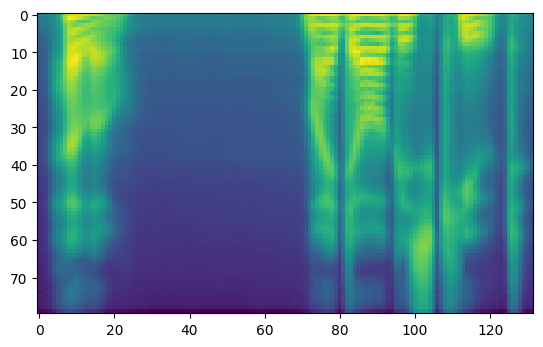

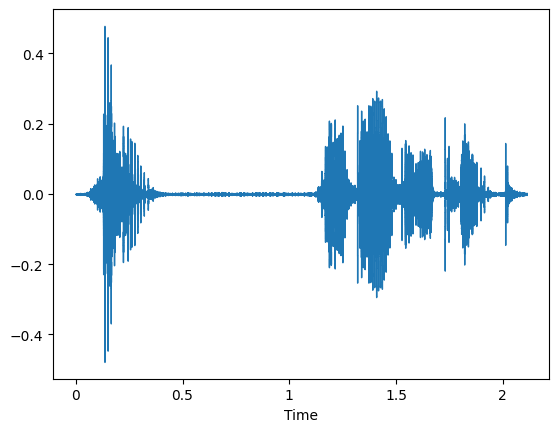

In [22]:
from transformers import SpeechT5Processor, SpeechT5ForTextToSpeech, SpeechT5HifiGan, set_seed
from IPython.display import Audio
from datasets import load_dataset
import soundfile as sf
import librosa
import torch

set_seed(42) # make results deterministic

model = SpeechT5ForTextToSpeech.from_pretrained("microsoft/speecht5_tts")
vocoder = SpeechT5HifiGan.from_pretrained("microsoft/speecht5_hifigan")
processor = SpeechT5Processor.from_pretrained("microsoft/speecht5_tts")

inputs = processor(text="Hello, my dog is cute.", return_tensors="pt")
speaker_embeddings = torch.zeros((1, 512))

# When using SpeechT5 for TTS, you should use "xvector speaker embeddings"
# to customize the output to a particular speaker’s voice characteristics
embeddings_dataset = load_dataset("Matthijs/cmu-arctic-xvectors", split="validation")
speaker_embeddings = torch.tensor(embeddings_dataset[42]["xvector"]).unsqueeze(0)

spectrogram = model.generate_speech(inputs["input_ids"], speaker_embeddings)
with torch.no_grad(): speech = vocoder(spectrogram)

display(Audio(speech.numpy(), rate=16000)) # You can hear the audio inputs

# You can plot the generated spectrogram
import matplotlib.pyplot as plt
plt.figure()
plt.imshow(spectrogram.T)
plt.show()

librosa.display.waveshow(speech.numpy(), sr=16000) # You can plot the generated waveform

sf.write("tts_example.wav", speech.numpy(), samplerate=16000) # You can save the audio to a .wav file

## Intermediate tasks:

* Connect the results from your answer to the previous intermediate task (i.e., conditioned language generation) to the SpeechT5 text-to-speech model, so as to produce speech outputs from the text generated by the model.
* Produce speech-based answers for the first 5 questions in the validation split from the TriviaQA dataset.
* Connect also the results from your answer to the first intermediate task (i.e., automated speech recognition) to the SpeechT5 model and the LLM, so as to take spoken questions as input and produce a speech output.
* Take the audio samples from 10 TriviaQA questions (as available in connection to the [SLUE-SQA-5 dataset](https://huggingface.co/datasets/asapp/slue-phase-2), in Huggingface datasets), and evaluate the answers generated for the spoken questions using the BLEU metric.
* Collect small audio samples, with your own voice, for the first 2 questions in the validation split from the TriviaQA dataset, and produce speech-based answers for these two questions.


### 1) Connecting the results from the previous intermediate task; and 2) Producing speech-based answers for the first 5 questions

In [23]:
# Add your solutions to the exercises
from datasets import load_dataset

dataset = load_dataset("lucadiliello/triviaqa")

In [24]:
N = 5 # select number of questions
lens = []
print('Questions:')
for i in dataset['validation']['question'][:N]:
  print(i)


print('\n Answers:')

lens = []
for i in dataset['validation']['answers'][:N]:
  lens.append(len(i[0].split()))
  print(i)

max_new_tokens = max(lens)

print(f'\n Maximum answer length is {max_new_tokens}\n')

print('\n Context:')
for i in dataset['validation']['context'][:N]:
  print(i[:1000])

Questions:
Who had an 80s No 1 hit with Hold On To The Nights?
What is the Japanese share index called?
Who had a 70s No 1 hit with Kiss You All Over?
Kagoshima international airport is in which country?
What was Eddie Murphy's first movie?

 Answers:
['richard marx']
['nikkei']
['exile']
['japan']
['48 hours']

 Maximum answer length is 2


 Context:
[DOC] [TLE] Hold On to the Nights"Hold On to the Nights" is a power ballad and number-one hit for American rock singer/songwriter/musician Richard Marx.  This was the fourth and final single released from his self-titled debut album, and the first to reach the top of the Billboard Hot 100 chart. [PAR] Written by Richard Marx, "Hold On to the Nights" reached the Billboard Hot 100 number 1 position on July 23, 1988, preventing Def Leppard's "Pour Some Sugar On Me" from reaching the top spot that same week. The song was on the chart for twenty-one weeks, and left the chart at number 65. From Marx' debut 1987 album, Richard Marx, the song als

In [25]:
from transformers import pipeline, AutoModelForQuestionAnswering, AutoTokenizer, set_seed
import evaluate

set_seed(42) # make results deterministic

model = "ahotrod/electra_large_discriminator_squad2_512"

tokenizer = AutoTokenizer.from_pretrained(model)
model = AutoModelForQuestionAnswering.from_pretrained(model)

generator = pipeline("question-answering", model=model, tokenizer=tokenizer)

predictions = []
for i in range(N):
    question = dataset['validation']['question'][i]

    context = dataset['validation']['context'][i][:1000]  # limit context size
    input_data = {"question": question, "context": context}

    pred = generator(input_data, max_new_tokens = max_new_tokens+20, num_return_sequences=1)
    predictions.append(pred['answer'].lower())

bleu = evaluate.load('bleu')
ans = dataset['validation']['answers'][:N]
results = bleu.compute(predictions=predictions, references=ans, max_order=2)
print(results)

{'bleu': 0.372677996249965, 'precisions': [0.5555555555555556, 0.25], 'brevity_penalty': 1.0, 'length_ratio': 1.2857142857142858, 'translation_length': 9, 'reference_length': 7}


In [26]:
for i, j in zip(ans, predictions):
  print(i, j)

['richard marx'] richard marx
['nikkei'] nikkei 225 stock average
['exile'] exile
['japan'] japan
['48 hours'] gumby


In [27]:
from transformers import SpeechT5Processor, SpeechT5ForTextToSpeech, SpeechT5HifiGan, set_seed
from IPython.display import Audio
from datasets import load_dataset
import soundfile as sf
import librosa
import torch

model = SpeechT5ForTextToSpeech.from_pretrained("microsoft/speecht5_tts")
vocoder = SpeechT5HifiGan.from_pretrained("microsoft/speecht5_hifigan")
processor = SpeechT5Processor.from_pretrained("microsoft/speecht5_tts")

for i, pred in enumerate(predictions):

  inputs = processor(text=pred, return_tensors="pt")
  speaker_embeddings = torch.zeros((1, 512))

  # When using SpeechT5 for TTS, you should use "xvector speaker embeddings"
  # to customize the output to a particular speaker’s voice characteristics
  embeddings_dataset = load_dataset("Matthijs/cmu-arctic-xvectors", split="validation")
  speaker_embeddings = torch.tensor(embeddings_dataset[42]["xvector"]).unsqueeze(0)

  spectrogram = model.generate_speech(inputs["input_ids"], speaker_embeddings)
  with torch.no_grad(): speech = vocoder(spectrogram)

  display(Audio(speech.numpy(), rate=16000)) # You can hear the audio inputs

  # You can plot the generated spectrogram
  #plt.figure()
  #plt.imshow(spectrogram.T)
  #plt.show()

  #librosa.display.waveshow(speech.numpy(), sr=16000) # You can plot the generated waveform

  #sf.write(f"tts_{i}.wav", speech.numpy(), samplerate=16000) # You can save the audio to a .wav file

### 3) Connect ASR to the LLM and TTS; and 4) Take the audio from 10 TriviaQA questions

In [28]:
# !rm -rf /root/.cache/huggingface

In [30]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [31]:
from datasets import load_dataset
file_path = '/content/drive/MyDrive/test-00000-of-00014.parquet'
df = load_dataset('parquet', data_files=file_path)

Generating train split: 0 examples [00:00, ? examples/s]

In [32]:
df['train']

Dataset({
    features: ['question_id', 'question_audio', 'question_speaker_id', 'raw_question_text', 'normalized_question_text', 'document_id', 'document_audio', 'document_speaker_id', 'raw_document_text', 'normalized_document_text', 'word2time', 'answer_spans'],
    num_rows: 171
})

In [33]:
df['train'][0]['question_audio']

{'path': 'squad-56be5523acb8001400a50330.wav',
 'array': array([-2.69056357e-14,  8.06022390e-14,  7.44432050e-14, ...,
        -3.05268659e-05,  1.22536021e-05,  2.32793991e-05]),
 'sampling_rate': 16000}

In [34]:
import torch
import librosa
from transformers import AutoProcessor, WhisperForConditionalGeneration
from datasets import load_dataset


processor = AutoProcessor.from_pretrained("openai/whisper-tiny.en")
model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-tiny.en")
questions = []

for i in range(0, 10):
  audio = df['train'][i]["question_audio"]["array"]
  audio = librosa.resample(audio, orig_sr=16000, target_sr=16000) # Resample audio to 16kHz (not needed in the case of this dataset)

  inputs = processor(audio, sampling_rate=16000, return_tensors="pt")
  input_features = inputs.input_features

  display(Audio(audio, rate=16000)) # You are able to hear the audio inputs

  generated_ids = model.generate(inputs=input_features)
  transcription = processor.batch_decode(generated_ids, max_length=250, skip_special_tokens=True)[0]

  print(transcription)
  questions.append(transcription)

print(f'All questions: \n {questions}')

 What California City last hosted the Super Bowl?


 How many broadcasts television partners does the NFL have?


 which regions have temporary climates.


 What work is useful for pastors?


 What type of education is sometimes present at religious schools in addition to the secular curriculum?


 What does the National Museum boast having from Adolf Hitler's private collection?


 AC and NC are complexity classes typically associated with what type of circuit.


 Where does Southern California's Megalopolis standard in terms of population nationwide?


 What does high levels of inequality do to growth in poor countries?


 What kind of university is the California Institute of Technology?
All questions: 
 [' What California City last hosted the Super Bowl?', ' How many broadcasts television partners does the NFL have?', ' which regions have temporary climates.', ' What work is useful for pastors?', ' What type of education is sometimes present at religious schools in addition to the secular curriculum?', " What does the National Museum boast having from Adolf Hitler's private collection?", ' AC and NC are complexity classes typically associated with what type of circuit.', " Where does Southern California's Megalopolis standard in terms of population nationwide?", ' What does high levels of inequality do to growth in poor countries?', ' What kind of university is the California Institute of Technology?']


In [35]:
answers = []
lens = []
# maximum words to answer a question
for i in range(0, 10):
  ans = df['train'][i]['answer_spans']['answer']
  answers.append(ans)
  lens.append(len(ans[0].split()))
max_new_tokens = max(lens)
print(f'The maximum number of words in an answer is {max_new_tokens}')

The maximum number of words in an answer is 2


In [36]:
for ans in answers:
  print(ans)

['san diego']
['three']
['mid-atlantic']
['larger catechism']
['religious', 'religious']
['paintings']
['boolean']
['third']
['reduce']
['private']


In [37]:
from transformers import pipeline, AutoModel, AutoTokenizer, set_seed, AutoModelForSeq2SeqLM

set_seed(42) # make results deterministic

model = "google/flan-t5-base"
context_flag = 1

tokenizer = AutoTokenizer.from_pretrained(model)
model = AutoModelForSeq2SeqLM.from_pretrained(model)

generator = pipeline("text2text-generation", model=model, tokenizer=tokenizer)

predictions = []
for i in range(0, 10):
  question = questions[i]
  if context_flag:
    context = df['train'][i]['normalized_document_text'] # limit context size
    instruction = f'Answer in less than {max_new_tokens+1} words.\n Question: {question}\nContext: {context}\n'
    input_prompt = f"Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\n{instruction}\n\n### Response:"
  else:
    input_prompt = question

  pred = generator(input_prompt, max_new_tokens = max_new_tokens+20, num_return_sequences=1)[0]['generated_text']
  predictions.append(pred.lower())

bleu = evaluate.load('bleu')
results = bleu.compute(predictions=predictions, references=answers, max_order=2)
print(results)

{'bleu': 0.058255172803546314, 'precisions': [0.11538461538461539, 0.029411764705882353], 'brevity_penalty': 1.0, 'length_ratio': 6.5, 'translation_length': 78, 'reference_length': 12}


In [38]:
for i, j in zip(answers, predictions):
  print(i, j)

['san diego'] san diego
['three'] ncaa has three
['mid-atlantic'] u s areas removed from bodies of water
['larger catechism'] the larger catechism
['religious', 'religious'] religious education is sometimes present at religious schools in addition to the secular curriculum.
['paintings'] the paintings are in the national museum's collection.
['boolean'] i think that the problem is a polygon partitioning its interior into triangles.
['third'] it is the third largest city in the united states.
['reduce'] increases in wages and wage scales
['private'] it is a private coeducational university.


In [39]:

from transformers import SpeechT5Processor, SpeechT5ForTextToSpeech, SpeechT5HifiGan, set_seed
from IPython.display import Audio
from datasets import load_dataset
import soundfile as sf
import librosa
import torch

set_seed(42) # make results deterministic

model = SpeechT5ForTextToSpeech.from_pretrained("microsoft/speecht5_tts")
vocoder = SpeechT5HifiGan.from_pretrained("microsoft/speecht5_hifigan")
processor = SpeechT5Processor.from_pretrained("microsoft/speecht5_tts")

# When using SpeechT5 for TTS, you should use "xvector speaker embeddings"
# to customize the output to a particular speaker’s voice characteristics
embeddings_dataset = load_dataset("Matthijs/cmu-arctic-xvectors", split="validation")
speaker_embeddings = torch.tensor(embeddings_dataset[40]["xvector"]).unsqueeze(0)

for pred in predictions:
  print(pred)
  inputs = processor(text=pred, return_tensors="pt")
  speaker_embeddings = torch.zeros((1, 512))

  spectrogram = model.generate_speech(inputs["input_ids"], speaker_embeddings)
  with torch.no_grad(): speech = vocoder(spectrogram)

  display(Audio(speech.numpy(), rate=16000)) # You can hear the audio inputs

# # You can plot the generated spectrogram
# import matplotlib.pyplot as plt
# plt.figure()
# plt.imshow(spectrogram.T)
# plt.show()

# librosa.display.waveshow(speech.numpy(), sr=16000) # You can plot the generated waveform

# sf.write("tts_example.wav", speech.numpy(), samplerate=16000) # You can save the audio to a .wav file

san diego


ncaa has three


u s areas removed from bodies of water


the larger catechism


religious education is sometimes present at religious schools in addition to the secular curriculum.


the paintings are in the national museum's collection.


i think that the problem is a polygon partitioning its interior into triangles.


it is the third largest city in the united states.


increases in wages and wage scales


it is a private coeducational university.


## 4) Produce speech-based answers for the first 2 questions in the validation split from TriviaQA using small audio samples of your own voice

In [40]:
import librosa

sr = 16000
audio3, sr = librosa.load("trivia1.wav", sr=sr)
display(Audio(audio3, rate=sr))
audio4, sr = librosa.load("trivia2.wav", sr=sr)
display(Audio(audio4, rate=sr))

audios=[audio3, audio4]

In [41]:
import torch
import librosa
from transformers import AutoProcessor, WhisperForConditionalGeneration
from datasets import load_dataset


processor = AutoProcessor.from_pretrained("openai/whisper-tiny.en")
model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-tiny.en")
questions = []

for audio in audios:
  inputs = processor(audio, sampling_rate=16000, return_tensors="pt")
  input_features = inputs.input_features

  generated_ids = model.generate(inputs=input_features)
  transcription = processor.batch_decode(generated_ids, max_length=250, skip_special_tokens=True)[0]
  questions.append([transcription])
  print(transcription)

 To where did Ethel read flee?
 Of what is ozone, a reactive part of oxygen?


In [42]:
from transformers import pipeline, AutoModel, AutoTokenizer, set_seed, AutoModelForSeq2SeqLM

set_seed(42) # make results deterministic

model = "google/flan-t5-base"

tokenizer = AutoTokenizer.from_pretrained(model)
model = AutoModelForSeq2SeqLM.from_pretrained(model)

generator = pipeline("text2text-generation", model=model, tokenizer=tokenizer)

max_new_tokens=1

predictions = []
for i in range(0, len(questions)):
  question = questions[i]

  instruction = f'Answer in less than {max_new_tokens+1} words.\n Question: {question}\n'
  input_prompt = f"Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\n{instruction}\n\n### Response:"

  pred = generator(input_prompt, max_new_tokens = max_new_tokens+20, num_return_sequences=1)[0]['generated_text']
  predictions.append(pred.lower())

In [43]:
for j in predictions:
  print(j)

i'm not sure.
i think it's a molecule of ozone.


In [44]:
from transformers import SpeechT5Processor, SpeechT5ForTextToSpeech, SpeechT5HifiGan, set_seed
from IPython.display import Audio
from datasets import load_dataset
import soundfile as sf
import librosa
import torch

set_seed(42) # make results deterministic

model = SpeechT5ForTextToSpeech.from_pretrained("microsoft/speecht5_tts")
vocoder = SpeechT5HifiGan.from_pretrained("microsoft/speecht5_hifigan")
processor = SpeechT5Processor.from_pretrained("microsoft/speecht5_tts")

# When using SpeechT5 for TTS, you should use "xvector speaker embeddings"
# to customize the output to a particular speaker’s voice characteristics
embeddings_dataset = load_dataset("Matthijs/cmu-arctic-xvectors", split="validation")
speaker_embeddings = torch.tensor(embeddings_dataset[42]["xvector"]).unsqueeze(0)

for pred in predictions:
  print(pred)
  inputs = processor(text=pred, return_tensors="pt")
  speaker_embeddings = torch.zeros((1, 512))

  spectrogram = model.generate_speech(inputs["input_ids"], speaker_embeddings)
  with torch.no_grad(): speech = vocoder(spectrogram)

  display(Audio(speech.numpy(), rate=16000)) # You can hear the audio inputs

# # You can plot the generated spectrogram
# import matplotlib.pyplot as plt
# plt.figure()
# plt.imshow(spectrogram.T)
# plt.show()

# librosa.display.waveshow(speech.numpy(), sr=16000) # You can plot the generated waveform

# sf.write("tts_example.wav", speech.numpy(), samplerate=16000) # You can save the audio to a .wav file

i'm not sure.


i think it's a molecule of ozone.


# Main problem

Students are tasked with joining together the speech recognition, language understanding and generation, and text-to-speech models, in order to build a conversational spoken question answering approach.

* The method should take as input speech utterances with questions.
* The language understanding and generation component should use as input a transcription for the current speech utterance, and optionally also transcriptions from previous speech utterances (i.e., the conversation context).
* The language understanding and generation component can explore different strategies for improving answer quality:
  * Use of large LLMs trained to follow instructions, e.g. with reinforcement learning from human feedback.
  * Prompting the language model with retrieved in-context examples.
  * Using parameter-efficient fine-ting with existing conversational question answering datasets (e.g., [the CoQA dataset](https://stanfordnlp.github.io/coqa/), which is [also available](https://huggingface.co/datasets/stanfordnlp/coqa) from HuggingFace datasets).
  * ...
* The text-to-speech component takes as input the results from language generation, and produces a speech output.
* Both the automated speech recognition and the text-to-speech components can explore different approaches, although students should attempt to justify their choices (e.g., if changing the automated speech recognition component, show that it achieves a lower WER).
* Collect small audio samples, with your own voice, for the questions in the first instance in the CoQA validation split, and show the results produced by your method for these questions.

## ASR Model

In [45]:
import torch
from transformers import AutoProcessor, WhisperForConditionalGeneration
import librosa
from IPython.display import Audio


# Load the ASR model and processor
processor = AutoProcessor.from_pretrained("openai/whisper-tiny.en")
model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-tiny.en")

def transcribe_audio(audio_path):
    audio, sr = librosa.load(audio_path, sr=16000)
    inputs = processor(audio, sampling_rate=16000, return_tensors="pt")
    input_features = inputs.input_features
    generated_ids = model.generate(inputs=input_features)
    transcription = processor.batch_decode(generated_ids, max_length=250, skip_special_tokens=True)[0]
    return transcription

## Language Understanding and Generation

In [46]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, pipeline

# Load the text generation model and tokenizer
model_name = "google/flan-t5-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
gen_model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
generator = pipeline("text2text-generation", model=gen_model, tokenizer=tokenizer)

def generate_answer(question, context=""):
    input_text = f"question: {question} context: {context}"
    result = generator(input_text, max_length=50)
    answer = result[0]['generated_text']
    return answer

## Text-to-Speech (TTS)

In [47]:
from transformers import SpeechT5Processor, SpeechT5ForTextToSpeech, SpeechT5HifiGan
import soundfile as sf
import numpy as np

# Load the TTS model and processor
tts_processor = SpeechT5Processor.from_pretrained("microsoft/speecht5_tts")
tts_model = SpeechT5ForTextToSpeech.from_pretrained("microsoft/speecht5_tts")
vocoder = SpeechT5HifiGan.from_pretrained("microsoft/speecht5_hifigan")

def text_to_speech(text, filename):
    inputs = tts_processor(text=text, return_tensors="pt")
    speaker_embeddings = torch.zeros((1, 512))  # Dummy speaker embeddings
    spectrogram = tts_model.generate_speech(inputs["input_ids"], speaker_embeddings)
    with torch.no_grad():
        speech = vocoder(spectrogram)
    speech_np = speech.numpy()
    sf.write(filename, speech_np, samplerate=16000)  # Save with the given filename
    return speech_np


## Speech-to-Speech QA

In [48]:
import os
import librosa
from IPython.display import Audio
from evaluate import load
from datasets import load_dataset


# Load the CoQA dataset validation split
ds = load_dataset('stanfordnlp/coqa', split='validation')

# Path to the folder containing WAV files
folder_path = '/content/'

# List all files in the folder and filter for WAV files
files = [f for f in os.listdir(folder_path) if f.endswith('.wav')]

# Sort the files to ensure they are processed in order
files.sort()

# Initialize WER and BLEU metrics
wer = load('wer')
bleu = load('bleu')

total_bleu_score = 0
nr_files = 0

# Initial context from the dataset
initial_context = ds['story'][0]

# Loop through the sorted files and process each one
context = initial_context
previous_qa = ""

# Loop through the sorted files and process each one
for i, file_name in enumerate(files):
    file_path = os.path.join(folder_path, file_name)

    # Load the audio file
    audio, sr = librosa.load(file_path, sr=16000)

    # Process the audio file (transcription, generation, TTS)
    transcription = transcribe_audio(file_path)
    question = ds['questions'][0][i]
    reference_answer = ds['answers'][0]['input_text'][i]
    # Append previous Q&A to the context with new lines
    full_context = f"{context}\n{previous_qa}"
    answer = generate_answer(transcription, context=full_context + '\n The answer must have less than 5 words.')
    # Update previous Q&A with the current question and answer, each on a new line
    previous_qa += f"Q: {transcription}\nA: {answer}\n"
    generated_speech_filename = os.path.join(folder_path, f"generated/generated_speech_{i}.wav")

    generated_speech = text_to_speech(answer, generated_speech_filename)

    # Calculate WER and BLEU
    wer_score = wer.compute(predictions=[transcription], references=[question])
    if len(reference_answer.split()) == 1:
      bleu_score = bleu.compute(predictions=[answer], references=[[reference_answer]], max_order=1)
    else:
      bleu_score = bleu.compute(predictions=[answer], references=[[reference_answer]], max_order=2)


    # Print the results
    print(f"Processing file: {file_name}")
    # Display the audio file
    display(Audio(audio, rate=sr))
    print("Transcription:", transcription)
    print("Reference Question:", question)
    print("WER Score:", wer_score, "\n")
    print("Reference Answer:", reference_answer)
    print("Generated Answer:", answer)
    print("BLEU Score:", bleu_score, "\n")

    total_bleu_score += bleu_score['bleu']
    nr_files += 1


    # Play the generated speech
    display(Audio(generated_speech, rate=16000))

avg_bleu_score = total_bleu_score/nr_files

print("Average BLEU Score:", avg_bleu_score, "\n")


Processing file: question01.wav


Transcription:  What color was cotton?
Reference Question: What color was Cotton?
WER Score: 0.25 

Reference Answer: white
Generated Answer: white
BLEU Score: {'bleu': 1.0, 'precisions': [1.0], 'brevity_penalty': 1.0, 'length_ratio': 1.0, 'translation_length': 1, 'reference_length': 1} 



Processing file: question02.wav


Transcription:  Where did she live?
Reference Question: Where did she live?
WER Score: 0.0 

Reference Answer: in a barn
Generated Answer: in a barn near a farm house
BLEU Score: {'bleu': 0.3779644730092272, 'precisions': [0.42857142857142855, 0.3333333333333333], 'brevity_penalty': 1.0, 'length_ratio': 2.3333333333333335, 'translation_length': 7, 'reference_length': 3} 



Processing file: question03.wav


Transcription:  Did she live alone?
Reference Question: Did she live alone?
WER Score: 0.0 

Reference Answer: no
Generated Answer: in a barn near a farm house
BLEU Score: {'bleu': 0.0, 'precisions': [0.0], 'brevity_penalty': 1.0, 'length_ratio': 7.0, 'translation_length': 7, 'reference_length': 1} 



Processing file: question04.wav


Transcription:  Who did she live with?
Reference Question: Who did she live with?
WER Score: 0.0 

Reference Answer: with her mommy and 5 sisters
Generated Answer: her mommy and 5 other sisters
BLEU Score: {'bleu': 0.7071067811865476, 'precisions': [0.8333333333333334, 0.6], 'brevity_penalty': 1.0, 'length_ratio': 1.0, 'translation_length': 6, 'reference_length': 6} 



Processing file: question05.wav


Transcription:  What color were her sisters?
Reference Question: What color were her sisters?
WER Score: 0.0 

Reference Answer: orange and white
Generated Answer: orange
BLEU Score: {'bleu': 0.0, 'precisions': [1.0, 0.0], 'brevity_penalty': 0.1353352832366127, 'length_ratio': 0.3333333333333333, 'translation_length': 1, 'reference_length': 3} 



Processing file: question06.wav


Transcription:  Was Cotton happy that she looked different than the rest of her family?
Reference Question: Was Cotton happy that she looked different than the rest of her family?
WER Score: 0.0 

Reference Answer: no
Generated Answer: She often wished she looked like the rest of her family.
BLEU Score: {'bleu': 0.0, 'precisions': [0.0], 'brevity_penalty': 1.0, 'length_ratio': 12.0, 'translation_length': 12, 'reference_length': 1} 



Processing file: question07.wav


Transcription:  What did she do to try to make herself the same color as her sisters?
Reference Question: What did she do to try to make herself the same color as her sisters?
WER Score: 0.0 

Reference Answer: she painted herself
Generated Answer: she used it to paint herself like them
BLEU Score: {'bleu': 0.0, 'precisions': [0.25, 0.0], 'brevity_penalty': 1.0, 'length_ratio': 2.6666666666666665, 'translation_length': 8, 'reference_length': 3} 



Processing file: question08.wav


Transcription:  Whose faint was it?
Reference Question: Whose paint was it?
WER Score: 0.25 

Reference Answer: the farmer
Generated Answer: Cotton
BLEU Score: {'bleu': 0.0, 'precisions': [0.0, 0.0], 'brevity_penalty': 0.36787944117144233, 'length_ratio': 0.5, 'translation_length': 1, 'reference_length': 2} 



Token indices sequence length is longer than the specified maximum sequence length for this model (529 > 512). Running this sequence through the model will result in indexing errors


Processing file: question09.wav


Transcription:  What did Cotton's mother and siblings do when they saw her painted orange?
Reference Question: What did Cotton's mother and siblings do when they saw her painted orange?
WER Score: 0.0 

Reference Answer: they started laughing
Generated Answer: Cotton
BLEU Score: {'bleu': 0.0, 'precisions': [0.0, 0.0], 'brevity_penalty': 0.1353352832366127, 'length_ratio': 0.3333333333333333, 'translation_length': 1, 'reference_length': 3} 



Processing file: question10.wav


Transcription:  Where did cotton's mother put her to clean the paint off?
Reference Question: Where did Cotton's mother put her to clean the paint off?
WER Score: 0.09090909090909091 

Reference Answer: a bucket of water
Generated Answer: a bucket of water
BLEU Score: {'bleu': 1.0, 'precisions': [1.0, 1.0], 'brevity_penalty': 1.0, 'length_ratio': 1.0, 'translation_length': 4, 'reference_length': 4} 



Processing file: question11.wav


Transcription:  What did the other cats do when cotton emerged from the bucket of water?
Reference Question: What did the other cats do when Cotton emerged from the bucket of water?
WER Score: 0.07142857142857142 

Reference Answer: licked her face
Generated Answer: licked her face
BLEU Score: {'bleu': 1.0, 'precisions': [1.0, 1.0], 'brevity_penalty': 1.0, 'length_ratio': 1.0, 'translation_length': 3, 'reference_length': 3} 



Processing file: question12.wav


Transcription:  Did they want cotton to change the color of her fur?
Reference Question: Did they want Cotton to change the color of her fur?
WER Score: 0.09090909090909091 

Reference Answer: no
Generated Answer: licked her face
BLEU Score: {'bleu': 0.0, 'precisions': [0.0], 'brevity_penalty': 1.0, 'length_ratio': 3.0, 'translation_length': 3, 'reference_length': 1} 



Average BLEU Score: 0.34042260451631456 



In [49]:
print(full_context)

Once upon a time, in a barn near a farm house, there lived a little white kitten named Cotton. Cotton lived high up in a nice warm place above the barn where all of the farmer's horses slept. But Cotton wasn't alone in her little home above the barn, oh no. She shared her hay bed with her mommy and 5 other sisters. All of her sisters were cute and fluffy, like Cotton. But she was the only white one in the bunch. The rest of her sisters were all orange with beautiful white tiger stripes like Cotton's mommy. Being different made Cotton quite sad. She often wished she looked like the rest of her family. So one day, when Cotton found a can of the old farmer's orange paint, she used it to paint herself like them. When her mommy and sisters found her they started laughing. 

"What are you doing, Cotton?!" 

"I only wanted to be more like you". 

Cotton's mommy rubbed her face on Cotton's and said "Oh Cotton, but your fur is so pretty and special, like you. We would never want you to be any o